In [1]:
import pylab
import os
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import ticker
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from IPython.display import HTML,display
import pandas as pd
mode2polfac=4*(5/(64*np.pi))**(1/2)

In [8]:
hf = h5py.File(f"/home/pratul/Downloads/Project/hybrids/1356hyb_EccTD_xlow045_GM.h5","r")  #Change hybrid IDs
data = hf['l2_m2']
t_ecc_hyb = np.real(data[:,0])
hp_ecc_hyb = np.real(data[:,1])
hc_ecc_hyb = np.real(data[:,2])
delta_t_hyb = np.abs(np.mean((np.diff(t_ecc_hyb))))

In [9]:
# parameters
M0 = 30
q = 1  # Change q accordingly
D = 1
M1=q*M0/(1+q)
M2=M0/(1+q)
D_SI = D*(10**(6))*PC_SI
M_SI = M0*MSUN_SI
mode2polfac=4*(5/(64*np.pi))**(1/2)

### Uniform Sampling through Interpolation

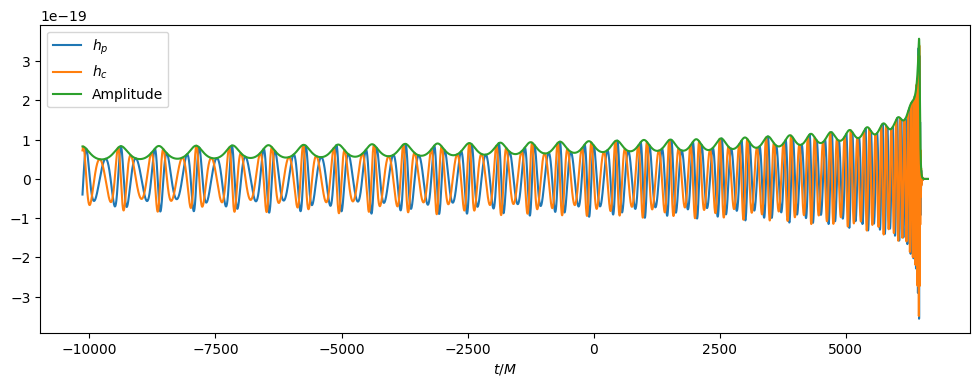

In [10]:
t_hyb = np.linspace(t_ecc_hyb.min(), t_ecc_hyb.max(), int((t_ecc_hyb.max()-t_ecc_hyb.min())/delta_t_hyb))

hp_int = interp1d(t_ecc_hyb, hp_ecc_hyb, kind = 'cubic', fill_value = 'extrapolate')
hc_int = interp1d(t_ecc_hyb, hc_ecc_hyb, kind = 'cubic', fill_value = 'extrapolate')

hp_hyb = hp_int(t_hyb) * (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
hc_hyb = hc_int(t_hyb) * (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)

t_hyb = t_hyb*(M0*MTSUN_SI)
h22_ecc_hyb = hp_hyb + 1j*hc_hyb

dataDict_hyb = {"t": t_hyb, "hlm": {(2, 2): h22_ecc_hyb}}

hf.close()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict_hyb["t"]/(M0*MTSUN_SI), np.real(dataDict_hyb["hlm"][(2, 2)]), label='$h_p$')
ax.plot(dataDict_hyb["t"]/(M0*MTSUN_SI), np.imag(dataDict_hyb["hlm"][(2, 2)]), label='$h_c$')
ax.plot(dataDict_hyb["t"]/(M0*MTSUN_SI), np.abs(dataDict_hyb["hlm"][(2, 2)]), label='Amplitude')

plt.xlabel('$t/M$')
plt.legend()

### Measuring eccentricity from gw_ecc package

In [26]:
method = 'AmplitudeFits'
return_dict_hyb = measure_eccentricity(fref_in = 1500*(M0*MTSUN_SI), method = method, dataDict = dataDict_hyb) #21
eccentricity = return_dict_hyb["eccentricity"]
print(eccentricity)

0.14481449083274278


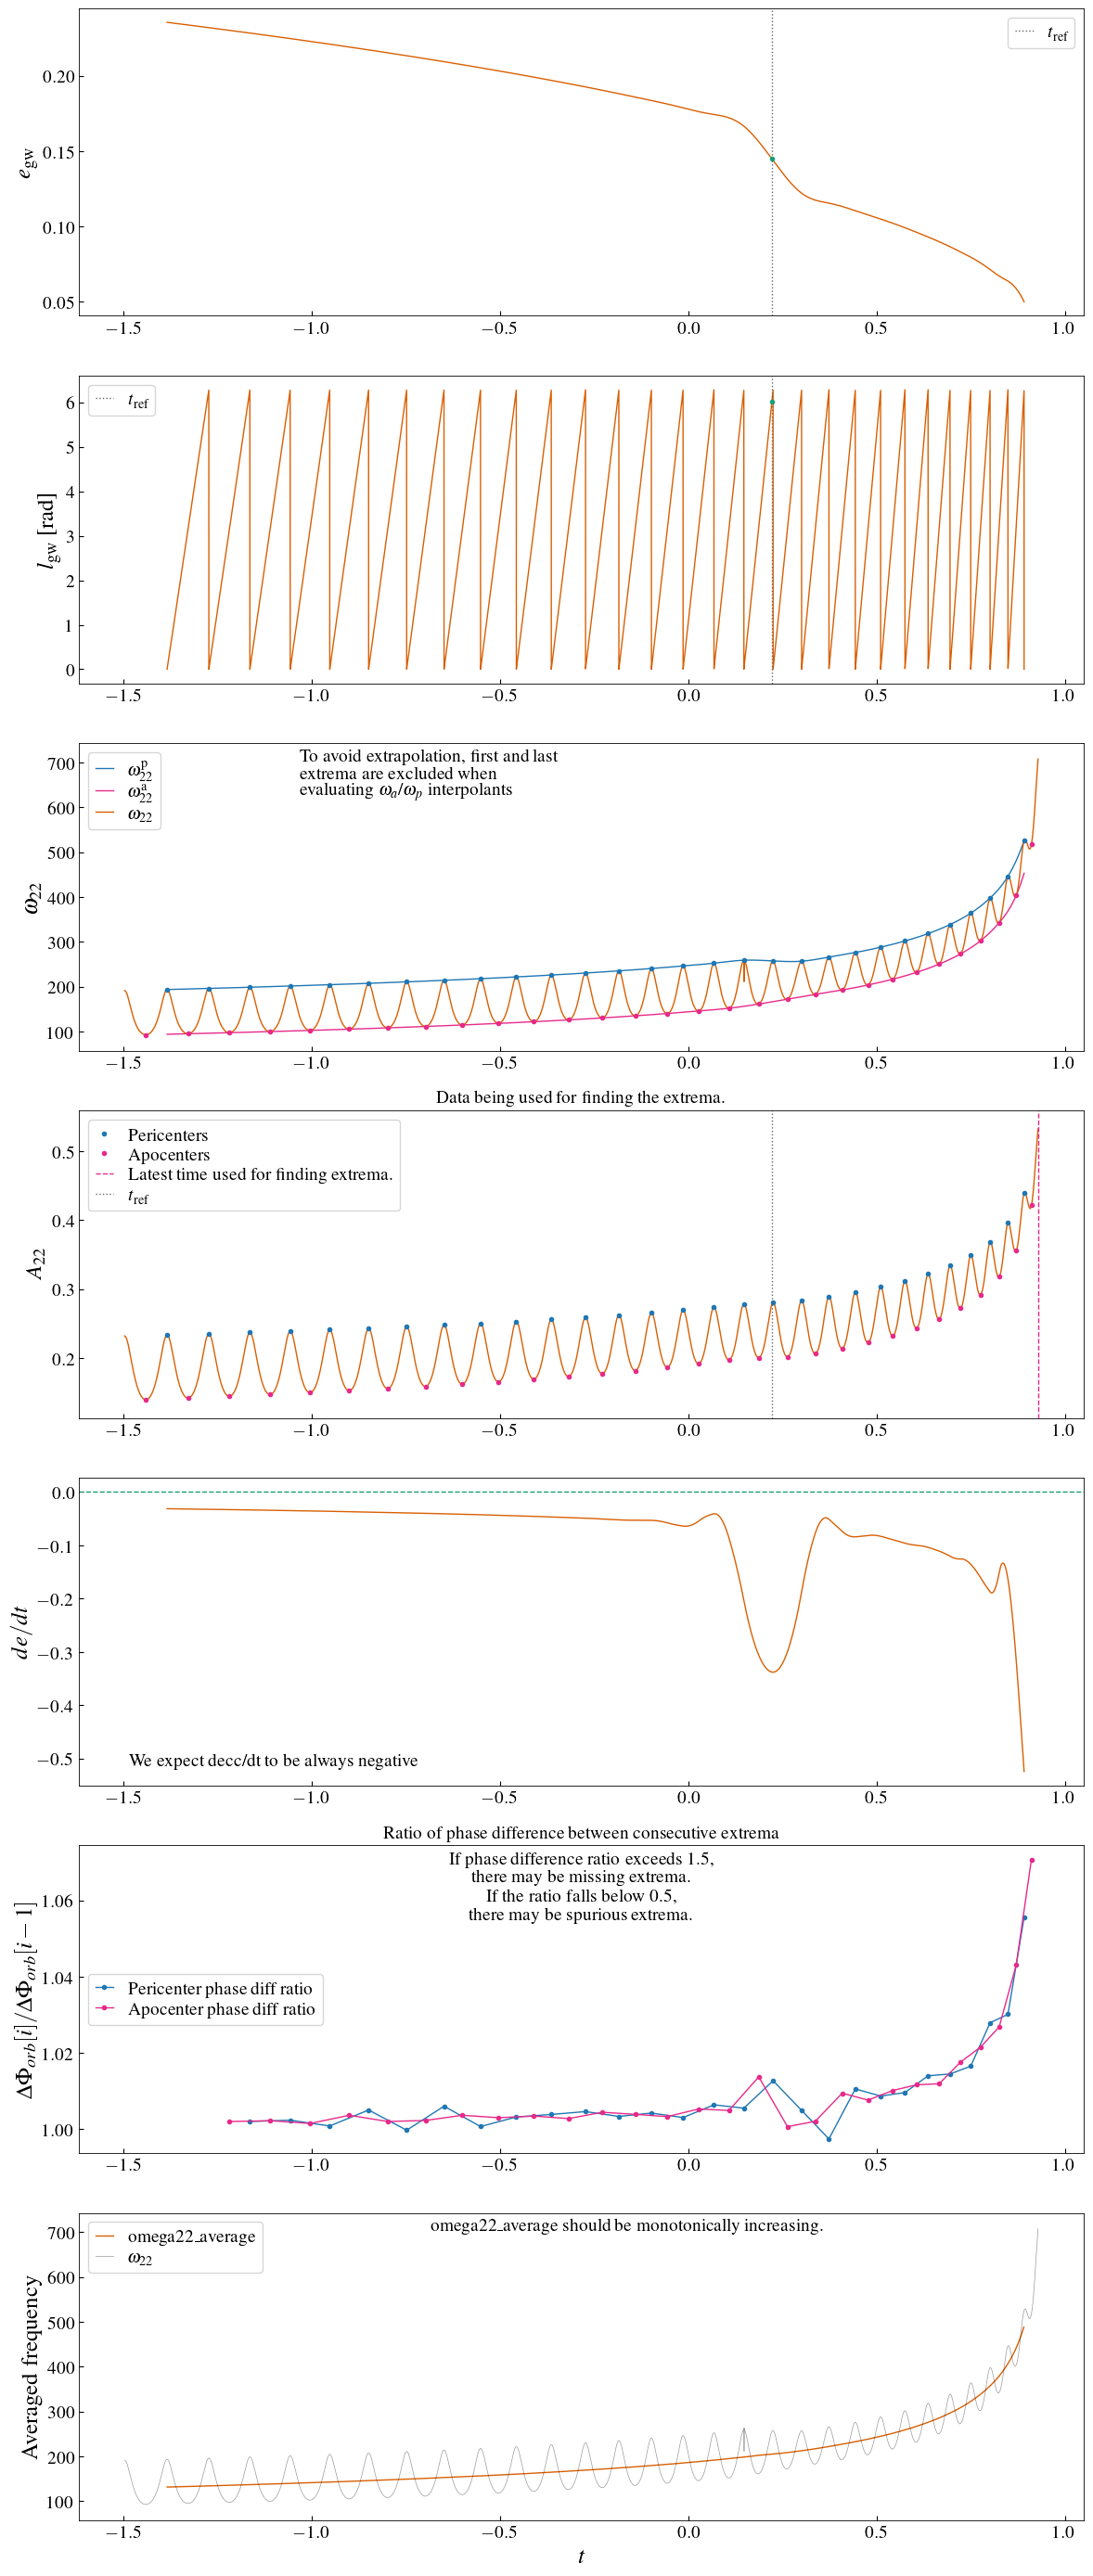

In [27]:
gw_ecc_obj = return_dict_hyb["gwecc_object"]
fig, ax = gw_ecc_obj.make_diagnostic_plots()

In [7]:
1500*(M0*MTSUN_SI)

0.22164709614946093

We calculate the reference eccentricity at 1500M for all the hybrids. We evolve EccentricTD with Eccentricity_initial and x0 = 0.045 and quote the reference eccentricity at xref = 0.075 for comparison with Hinder et al. The details are as follows:

ID      Eccentricity_gw_hyb     Eccentricity_initial  Mean_anomaly   Eccentricity_gw_ecctd

1355    0.0797145754363584      0.127                  2.739          0.09140399878263361

1356    0.14481449083274278     0.163                  1.606           0.1265389178045324

1357    0.15230653161271257     0.222                 -1.020           0.18302385399838483

1358    0.12486456225978315     0.226                 -2.937          0.18302385399838483

1359    0.13768348844491574     0.227                  1.850          0.18302385399838483

1360    0.1849760535174345      0.302                  0.730          0.25456218977188205

1361    0.1832247842673892      0.305                  1.146           0.25456218977188205
 
1362    0.2590333979090005      0.372                 -0.726           0.3388755558384311

1363    0.25829733806294863     0.376                  0.385          0.3388755558384311

1364    0.0724410272801227      0.108                 -2.495          0.09149210585445311

1365    0.07936315225922563     0.145                 -1.116           0.1117094038057489

1366    0.1380930382387887      0.218                  0.096           0.18415353471966467

1367    0.14409482102417914     0.220                 -0.964           0.18415353471966467

1368    0.1409317304582557      0.222                 -1.553           0.18415353471966467

1369    0.2797001686788573      0.367                 -2.489           0.3392834563365529

1370    0.24415364872117018     0.367                  0.754           0.3392834563365529

1371    0.09244377431005435     0.133                 -1.757           0.10938815816994119

1372    0.13835371157440168     0.212                 -2.101           0.1669569410270606

1373    0.1355684067488725      0.214                 -2.655           0.1669569410270606

1374    0.2600552788178846      0.359                 -2.953           0.32291318276856806

# Hybrids new table

Next we try to compute the reference eccentricity at x0 = 0.075 in order to compare with Hinder et al

In [47]:
# parameters
M0 = 30
D = 1
x_ref=0.0694
xlow = 0.045
f_low =(xlow**(3/2)/(M0*MTSUN_SI*math.pi)) 
f_ref =(x_ref**(3/2)/(M0*MTSUN_SI*math.pi))  
D_SI = D*(10**(6))*PC_SI
M_SI = M0*MSUN_SI
mode2polfac=4*(5/(64*np.pi))**(1/2)
print(f_low)

20.563550931756406


In [48]:
file_src = "/home/pratul/Downloads/Project/22-hybrids/"
for x in os.listdir(file_src):
        #print(os.path.basename(x))
        hf = h5py.File(f"/home/pratul/Downloads/Project/22-hybrids/"+str(x),"r")  #Change hybrid IDs
        data = hf['l2_m2']
        t_ecc_hyb = np.real(data[:,0])
        hp_ecc_hyb = np.real(data[:,1])
        hc_ecc_hyb = np.real(data[:,2])
        delta_t_hyb = np.abs(np.mean((np.diff(t_ecc_hyb))))
        
        t_hyb = np.linspace(t_ecc_hyb.min(), t_ecc_hyb.max(), int((t_ecc_hyb.max()-t_ecc_hyb.min())/delta_t_hyb))

        hp_int = interp1d(t_ecc_hyb, hp_ecc_hyb, kind = 'cubic', fill_value = 'extrapolate')
        hc_int = interp1d(t_ecc_hyb, hc_ecc_hyb, kind = 'cubic', fill_value = 'extrapolate')
        
        hp_hyb = hp_int(t_hyb) * (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        hc_hyb = hc_int(t_hyb) * (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)

        t_hyb = t_hyb*(M0*MTSUN_SI)
        h22_ecc_hyb = hp_hyb + 1j*hc_hyb

        dataDict_hyb = {"t": t_hyb, "hlm": {(2, 2): h22_ecc_hyb}}

        hf.close()
        
        method = 'AmplitudeFits'
        return_dict_hyb = measure_eccentricity(fref_in = f_ref, method = method, dataDict = dataDict_hyb)
        eccentricity = return_dict_hyb["eccentricity"]
        print(x,'','','',eccentricity)


1357hyb_EccTD_xlow045_GM.h5    0.2018102179845256
1361hyb_EccTD_xlow045_GM.h5    0.27820304814554164
1368hyb_EccTD_xlow045_GM.h5    0.20285806655222405
1374hyb_EccTD_xlow045_GM.h5    0.35007914883984703
1364hyb_EccTD_xlow045_GM.h5    0.10137877044925758
1360hyb_EccTD_xlow045_GM.h5    0.27811251495704836
1366hyb_EccTD_xlow045_GM.h5    0.20406038469611976
1373hyb_EccTD_xlow045_GM.h5    0.18428887132868133
1358hyb_EccTD_xlow045_GM.h5    0.20186504026734065
1362hyb_EccTD_xlow045_GM.h5    0.36641164611975396
1365hyb_EccTD_xlow045_GM.h5    0.1236861191179387
1371hyb_EccTD_xlow045_GM.h5    0.12111823699384705
1372hyb_EccTD_xlow045_GM.h5    0.18407416007917055
1369hyb_EccTD_xlow045_GM.h5    0.367239750831854
1367hyb_EccTD_xlow045_GM.h5    0.20288102143983788
1359hyb_EccTD_xlow045_GM.h5    0.20164609098288755
1370hyb_EccTD_xlow045_GM.h5    0.36697982376316285
1355hyb_EccTD_xlow045_GM.h5    0.09826006510705865
1363hyb_EccTD_xlow045_GM.h5    0.36652823230441733
1356hyb_EccTD_xlow045_GM.h5    0.10

In [10]:
e0_hybrid = [0.120, 0.163, 0.227, 0.227, 0.227, 0.299, 0.299, 0.373, 0.373, 0.120, 0.145, 0.228, 0.228, 0.228, 0.373, 0.373, 0.142, 0.209, 0.209, 0.359]

eref_hybrid = [0.05085995102504226, 0.09218306963743916, 0.1710781098869042, 0.16003719907464742, 0.18358518107338873, 0.25261294632547704, 0.2495848582394129, 0.33643353468078285, 0.33463655282696836, 0.08302632340082661, 0.09416043107237215, 0.15657693314951804, 0.18416193402813463,  0.1823230304707466, 0.32945300590465565, 0.340855682480218, 0.09673498006955161, 0.15562933249339717,0.15904305293784993, 0.3257271582447988] 

eref_ecctd = [0.09140399878263361, 0.1265389178045324, 0.18302385399838483, 0.18302385399838483, 0.18302385399838483, 0.25456218977188205, 0.25456218977188205, 0.3388755558384311, 0.3388755558384311, 0.09149210585445311, 0.1117094038057489, 0.18415353471966467, 0.18415353471966467, 0.18415353471966467, 0.3392834563365529, 0.3392834563365529, 0.10938815816994119, 0.1669569410270606, 0.1669569410270606, 0.32291318276856806]


len(eref_ecctd)

20

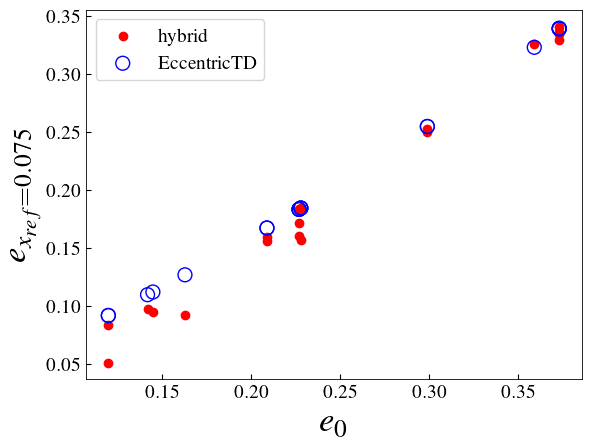

In [22]:
plt.scatter(e0_hybrid, eref_hybrid, label = 'hybrid', c = 'red')
plt.scatter(e0_hybrid, eref_ecctd, facecolors='none', edgecolors='b',label = 'EccentricTD', s=100)
plt.xlabel("$e_0$", size =25)
plt.ylabel("$e_{x_{ref} = 0.075}$", size =25)
plt.legend(frameon = True)